In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


In [3]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 51s 4us/step


In [4]:
print(train_images.shape)

(60000, 28, 28)


In [6]:
len(train_labels)

60000

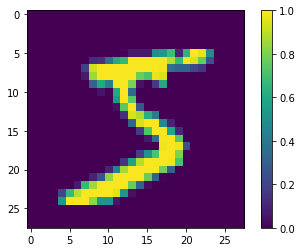

In [29]:
plt.imshow(train_images[0])
plt.colorbar()

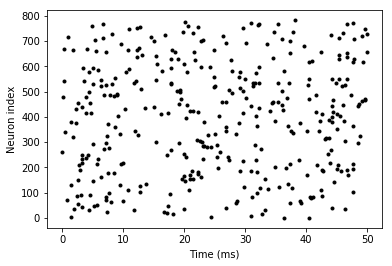

In [41]:
from brian2 import *

start_scope()


#there are 784 input neurons for every visual pixel. 

visual_input = numpy.reshape((train_images[0]),784)

P = PoissonGroup(784, visual_input*Hz + 10*Hz)

spikemon = SpikeMonitor(P)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

WARNING    "tau" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "synapses", but also exists in the run namespace with the value 37. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


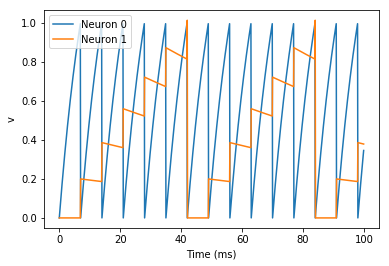

In [39]:
from brian2 import *

start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# The synapses currently run from layer G to layer G. We'd want the poisson layer to connect instead
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

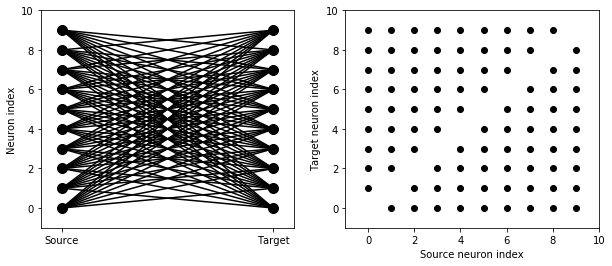

In [43]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)

#S.connect function contains a probability mapping that one neuron is conected to another neuron
S.connect(condition='i!=j', p=1)



#don't worry about this code - it's just a black box
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

There's a function on the synapes page to adjust weight in proportion to how far away the neurons are from each other in each line (can be used to implement vogel's mexican hat model)

STDP is normally defined by an equation something like this:

Δw=∑tpre∑tpostW(tpost−tpre)


That is, the change in synaptic weight w is the sum over all presynaptic spike times tpre and postsynaptic spike times tpost of some function W of the difference in these spike times. A commonly used function W is:

W(Δt)={Apree−Δt/τpreAposteΔt/τpostΔt>0Δt<0

WARNING    "t" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 37. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 37. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


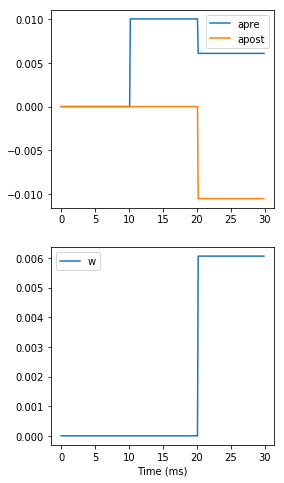

In [46]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

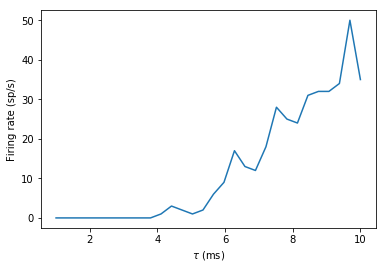

In [48]:
start_scope() 
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');